In [22]:
def find(place):
    import json
    with open('Saint+Petersburg-finalized.json') as json_file:
        data = json.load(json_file)
        for p in data:
            if place in p['title']:
                return (p['lat'], p['lng'])

In [23]:
def findLocation(begin_end):
    i = 0
    near = 1000
    point = 0
    findRoad = 0
    for road in coords:
        for i in range(len(road)):
            a = geopy.distance.geodesic(begin_end, road[i]).km
            if a < near:
                near = a
                point = road[i]
                findRoad = road
            i += 1
    ind0 = coords.index(findRoad)
    ind1 = coords[ind0].index(point)
    coords[ind0].insert(ind1+1,begin_end)
    return coords

In [24]:
def nearest_stops(begin, end):
    # nearest bus stops
    import pandas as pd
    import geopy.distance
    df = pd.read_csv("public_transport_spb")
    stops = df["coordinates"]
    nearBegin = []
    nearEnd = []
    for i in range(len(stops)):
        distBegin = geopy.distance.geodesic(begin, stops[i]).km
        distEnd = geopy.distance.geodesic(end, stops[i]).km
        if distBegin <= 0.5:
            nearBegin.append(stops[i])
        if distEnd <= 0.8:
            nearEnd.append(stops[i])

    # remove repeating elements
    nearBegin = set(nearBegin)
    nearEnd = set(nearEnd)
    
    return nearBegin, nearEnd

In [25]:
def nearestBusinStops(stops):
    stops = nearest_stops(begin, end)
    # nearest bus in nesrest stops
    df = pd.read_csv("public_transport_spb")
    stopsBegin = list(stops[0])
    stopsEnd = list(stops[1])
    nearBusBegin = []
    nearBusEnd = []
    for i in range(len(stopsBegin)):
        number = list(df.loc[df['coordinates'] == stopsBegin[i]]['route_short_name'])
        coordinate = list(df.loc[df['coordinates'] == stopsBegin[i]]['coordinates'])
        nearBusBegin.append(number)

    nearBusEnd = []
    for j in range(len(stopsEnd)):
        number = list(df.loc[df['coordinates'] == stopsEnd[j]]['route_short_name'])
        coordinate = list(df.loc[df['coordinates'] == stopsEnd[j]]['coordinates'])
        nearBusEnd.append(number)
    return nearBusBegin, nearBusEnd

In [26]:
# try to find direct route
def suitableBus(nearBusBegin, nearBusEnd):
    flatNearBusBegin  = list(set([val for sublist in nearBusBegin for val in sublist]))
    flatNearBusEnd  = list(set([val for sublist in nearBusEnd for val in sublist]))

    suitableBuses = []
    for i in range(len(flatNearBusBegin)):
        for j in range(len(flatNearBusEnd)):
            if flatNearBusBegin[i] == flatNearBusEnd[j]:
                suitableBuses.append(flatNearBusBegin[i])
    return suitableBuses

In [27]:
def coordsBeginEnd(nearBusBegin, nearBusEnd):
    stopsBegin = list(stops[0])
    stopsEnd = list(stops[1])
    c = []
    coordsBegin = []
    for i in range(len(nearBusBegin)):
        if suitableBuses[0] in nearBusBegin[i]:
            c.append(i)
            coordsBegin.append(stopsBegin[i])
    coordsEnd = []
    for i in range(len(nearBusEnd)):
        if suitableBuses[0] in nearBusEnd[i]:
            c.append(i)
            coordsEnd.append(stopsEnd[i])
    return coordsBegin, coordsEnd

In [28]:
def findSuitNumber(suitableBuses):
    df = pd.read_csv("public_transport_spb")
    stopsBegin = list(stops[0])
    stopsEnd = list(stops[1])
    suitNumber = []
    minDist = 1000000

    for k in range(len(suitableBuses)):
        #for k in range(len(suitableBuses)):
        busPath = df.loc[df['route_short_name'] == suitableBuses[k]]
        busPathDirect = busPath.loc[busPath['direction'] == 'Прямое']
        busPathReverse = busPath.loc[busPath['direction'] == 'Обратное']
        c = []
        coordsBegin = []
        for i in range(len(nearBusBegin)):
            if suitableBuses[k] in nearBusBegin[i]:
                c.append(i)
                coordsBegin.append(stopsBegin[i])
        coordsEnd = []
        for i in range(len(nearBusEnd)):
            if suitableBuses[k] in nearBusEnd[i]:
                c.append(i)
                coordsEnd.append(stopsEnd[i])

        if len(busPathReverse) > 2:
            for i in coordsBegin:
                for j in coordsEnd:
                        a = busPath.loc[busPath['coordinates'] == i].index[0]
                        b = busPath.loc[busPath['coordinates'] == j].index[0] 
                        data = busPath.loc[a:b, :]
                        dist = data["stop_distance"].sum()
                        if dist < minDist and dist != 0:
                            minDist = dist
                            stopBegin = i
                            stopEnd = j
            a = [suitableBuses[k], minDist, stopBegin, stopEnd]
            suitNumber.append(a)



        else:
            if list(busPath['coordinates']).index(coordsBegin[0]) > list(busPath['coordinates']).index(coordsEnd[0]):
                for i in coordsBegin:
                    for j in coordsEnd:
                        a = busPath.loc[busPath['coordinates'] == j].index[0]
                        b = busPath.loc[busPath['coordinates'] == i].index[0]
                        data = busPath.loc[a:b, :]
                        dist = data["stop_distance"].sum()
                        if dist < minDist:
                            minDist = dist
                            stopBegin = j
                            stopEnd = i
                a = [suitableBuses[k], minDist, stopBegin, stopEnd]
                suitNumber.append(a)
            else:
                for i in coordsBegin:
                    for j in coordsEnd:
                        a = busPath.loc[busPath['coordinates'] == i].index[0]
                        b = busPath.loc[busPath['coordinates'] == j].index[0]
                        data = busPath.loc[a:b, :]
                        dist = data["stop_distance"].sum()
                        if dist < minDist:
                            minDist = dist
                            stopBegin = i
                            stopEnd = j
                a = [suitableBuses[k], minDist, stopBegin, stopEnd]
                suitNumber.append(a)
    return suitNumber

In [29]:
def printAll(suitNumber):
    from operator import itemgetter
    df = pd.read_csv("public_transport_spb")
    opt = min(suitNumber,key=itemgetter(1))
    print("подходящий транспорт №", opt[0])
    print("ехать", opt[1],"км")
    beginStop = df.loc[df['coordinates'] == opt[2]]["stop_name"].iloc[0] 
    print('с останвоки', df.loc[df['coordinates'] == opt[2]]["stop_name"].iloc[0] )
    endStop = df.loc[df['coordinates'] == opt[3]]["stop_name"].iloc[0]
    print('до остановки', df.loc[df['coordinates'] == opt[3]]["stop_name"].iloc[0])
    typeOfTransport = list(df.loc[df['route_short_name'] == opt[0]]['transport_type'])[0]
    print('вид транспорта', typeOfTransport)

    distBus = opt[1]
    return opt, typeOfTransport, beginStop, endStop

In [30]:
def coosdinatesStopsBus():
    df = pd.read_csv("public_transport_spb")
    busPath = df.loc[df['route_short_name'] == opt[0]]
    a = busPath.loc[busPath['coordinates'] == opt[2]].index[0]
    b = busPath.loc[busPath['coordinates'] == opt[3]].index[0]
    data = busPath.loc[a:b, :]
    quant = len(data)
    print('кол-во останвок', quant - 1)
    coosdinatesStopsBuses = data['coordinates']
    return coosdinatesStopsBuses

In [31]:
def calcTime(coosdinatesStopsBuses):
    coordStopBegin = list(coosdinatesStopsBuses)[0]
    coordStopEnd = list(coosdinatesStopsBuses)[-1]
    distStopBegin = geopy.distance.geodesic(begin,coordStopBegin).km
    distStopEnd = geopy.distance.geodesic(end,coordStopEnd).km
    distBus = opt[1]
    timeStopBegin = distStopBegin / 5 * 60 # 5 км/ч скорость пешком
    timeStopEnd = distStopEnd / 5 * 60
    timeBus = distBus / 20 * 60 # 20 км/ч скорость на автобусе
    timeCommonByBus = int(round(timeBus + timeStopBegin + timeStopEnd, 0))
    print(timeCommonByBus)
    return timeCommonByBus

In [32]:
# with transfer

In [33]:
def nearest_stopsTR(begin, end):
    # nearest bus stops
    import pandas as pd
    import geopy.distance
    df = pd.read_csv("public_transport_spb")
    stops = df["coordinates"]
    nearBegin = []
    nearEnd = []
    for i in range(len(stops)):
        distBegin = geopy.distance.geodesic(begin, stops[i]).km
        distEnd = geopy.distance.geodesic(end, stops[i]).km
        if distBegin <= 0.5:
            nearBegin.append(stops[i])
        if distEnd <= 0.5:
            nearEnd.append(stops[i])

    # remove repeating elements
    nearBegin = set(nearBegin)
    nearEnd = set(nearEnd)
    
    return nearBegin, nearEnd

In [34]:
def nearestBusinStopsTR(stops):
    stops = nearest_stops(begin, end)
    # nearest bus in nesrest stops
    df = pd.read_csv("public_transport_spb")
    stopsBegin = list(stops[0])
    stopsEnd = list(stops[1])
    nearBusBegin = []
    nearBusEnd = []
    for i in range(len(stopsBegin)):
        number = list(df.loc[df['coordinates'] == stopsBegin[i]]['route_id'])
        coordinate = list(df.loc[df['coordinates'] == stopsBegin[i]]['coordinates'])
        
        nearBusBegin.append(number)

    nearBusEnd = []
    for j in range(len(stopsEnd)):
        number = list(df.loc[df['coordinates'] == stopsEnd[j]]['route_id'])
        coordinate = list(df.loc[df['coordinates'] == stopsEnd[j]]['coordinates'])
        
        nearBusEnd.append(number)
    return nearBusBegin, nearBusEnd

In [35]:
def findPotentilBuses(flatNearBusBegin , flatNearBusEnd):
    #find stops where meet both buses
    df = pd.read_csv("public_transport_spb")
    common = []
    buses = []
    for i in flatNearBusBegin:
        for j in flatNearBusEnd:
            a = list(df.loc[df['route_id'] == i]['coordinates'])
            b = list(df.loc[df['route_id'] == j]['coordinates'])
            commonStops = list(set(a).intersection(b))
            if len(commonStops) > 0:
                print(i,j, commonStops[0])
                buses.append([i,j, commonStops])
                common.append(commonStops)
    len(common)
    return buses

In [36]:
def findTransfer(buses, directionBegin, directionEnd):
    df = pd.read_csv("public_transport_spb")
    ok = []
    for i in range(len(buses)):
        a = df.loc[df['route_id'] == buses[i][0]]
        b = a.loc[a['direction'] == directionBegin]['coordinates']
        coordinatesBeginStops = list(set(b).intersection(stops[0]))

        try:
            numberBegin = a.loc[a['coordinates'] == coordinatesBeginStops[0]]['number']
            beginCoord = a.loc[a['coordinates'] == coordinatesBeginStops[0]]['coordinates']
        except:
            continue

        aEnd = df.loc[df['route_id'] == buses[i][1]]
        bEnd = aEnd.loc[aEnd['direction'] == directionEnd]['coordinates']
        coordinatesEndStops = list(set(bEnd).intersection(stops[1]))

        try:
            numberEnd = aEnd.loc[aEnd['coordinates'] == coordinatesEndStops[0]]['number']
            endCoord = aEnd.loc[aEnd['coordinates'] == coordinatesEndStops[0]]['coordinates']
        except:
            continue

        okBegin = []
        for j in buses[i][2]:
            n = a.loc[a['coordinates'] == j]['number']
            if list(n)[0] > list(numberBegin)[0]:
                okBegin.append(j)
                
        okEnd = []
        
        for k in buses[i][2]:
            n = aEnd.loc[aEnd['coordinates'] == k]['number']
            if list(n)[0] < list(numberEnd)[0]:
                okEnd.append(k)
                
        suitStops = list(set(okEnd).intersection(okBegin))
        
        try:
            suit = [buses[i][0],directionBegin,list(beginCoord)[0], buses[i][1],directionEnd,list(endCoord)[0], suitStops]
        except:
            continue
        ok.append(suit)
    return ok

In [37]:
def findBestTransfer(allOk):
    df = pd.read_csv("public_transport_spb")
    d = 1000000
    bus1 = 0
    bus2 = 0
    stops = 0
    for i in allOk:   
        aF = df.loc[df['route_id'] == i[0]]
        bF = aF.loc[aF['direction'] == i[1]]
        indexBeginF = bF.loc[bF['coordinates'] == i[2]].index[0]


        try:
            indexEndF = bF.loc[bF['coordinates'] == i[6][0]].index[0]
        except:
            continue

        dataF = bF.loc[indexBeginF:indexEndF, :]
        distF = dataF["stop_distance"].sum()

        aS = df.loc[df['route_id'] == i[3]]
        bS = aS.loc[aS['direction'] == i[4]]

        try:
            indexBeginS = bS.loc[bS['coordinates'] == i[6][0]].index[0]
        except:
            continue

        indexEndS = bS.loc[bS['coordinates'] == i[5]].index[0]
        dataS = bS.loc[indexBeginS:indexEndS, :]
        distS = dataS["stop_distance"].sum()

        dist = distF + distS

        if dist < d:
            d = dist
            bus1 = i[0]
            bus2 = i[3]
            stopTransfer = i[6][0]
            direction1 = i[1]
            stopBegin = i[2]
            direction2 = i[4]
            stopEnd = i[5]
    print(d, bus1,direction1, stopBegin, stopTransfer, bus2,direction2, stopEnd)
    return d, bus1,direction1, stopBegin, stopTransfer, bus2,direction2, stopEnd

In [38]:
def calcTimeTR(coosdinatesStopsBuses):
    coordStopBegin = list(coosdinatesStopsBuses)[0]
    coordStopEnd = list(coosdinatesStopsBuses)[-1]
    distStopBegin = geopy.distance.geodesic(begin,coordStopBegin).km
    distStopEnd = geopy.distance.geodesic(end,coordStopEnd).km
    distBus = d
    timeStopBegin = distStopBegin / 5 * 60 # 5 км/ч скорость пешком
    timeStopEnd = distStopEnd / 5 * 60
    timeBus = distBus / 20 * 60 # 20 км/ч скорость на автобусе
    timeCommonByBus = int(round(timeBus + timeStopBegin + timeStopEnd, 0))
    print(timeCommonByBus)
    return timeCommonByBus

In [39]:
def downloadData(area):
    import json
    with open(area, 'r') as file:
        data = json.load(file)
    return data

In [40]:
def importData():
    import requests
    import json
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
    [out:json];
    area[name="Санкт-Петербург"]->.b;
    rel(area.b)[name="Василеостровский район"];
    map_to_area -> .a;
    way[highway~"^(motorway|trunk|primary|secondary|tertiary|unclassified|living_street|pedestrian|bus_guideway|residential)$"](area.a);
    out geom;
    relation[highway~"^(motorway|trunk|primary|secondary|tertiary|unclassified|living_street|pedestrian|bus_guideway|residential)$"](area.a);
    out geom;
    """

    torport = 9050
    proxies = {
        'http': "socks5h://localhost:{}".format(torport),
        'https': "socks5h://localhost:{}".format(torport)
    }


    response = requests.get(overpass_url, 
                            params={'data': overpass_query}, proxies = proxies)
    data = response.json()
    return data

In [41]:
def maxminCoords():
    allDistrict = ['centralnii_district.txt', 'petrogradskii_district.txt', 'kalininskii_district.txt', 'primorskii_district.txt', 'admiralteiskii_district.txt', 'nevskii_district.txt', 'kirovskii_district.txt', 'frunzenskii_district.txt', 'vyborgskii_district.txt', 'vasileostrovskii_district.txt','moskovskii_district.txt' ]
    d = {}
    import json
    for n in allDistrict:
        with open(n, 'r') as file:
            data = json.load(file)
        import numpy as np
        import matplotlib.pyplot as plt
        coords = [[] for x in range(len(data['elements']))]
        for i in range(len(data['elements'])):
            if 'geometry' in data['elements'][i]:
                    for j in range(len(data['elements'][i]['geometry'])):
                        lon = data['elements'][i]['geometry'][j]['lon']
                        lat = data['elements'][i]['geometry'][j]['lat']
                        coords[i].append((lon, lat))
        X = np.array(coords[0])
        flat_coords = [item for sublist in coords for item in sublist]
        maxlon = max(flat_coords, key=lambda x: x[0])[0]
        minlon = min(flat_coords, key=lambda x: x[0])[0]
        maxlat = max(flat_coords, key=lambda x: x[1])[1]
        minlat = min(flat_coords, key=lambda x: x[1])[1]

        d[n] = [maxlon, minlon, maxlat, minlat]
    return d

In [42]:
def findDistrict(begin, end, busesStops):
    k = []
    for i in d:
        if begin[1] <= d[i][0] and begin[1] >= d[i][1] and begin[0] <= d[i][2] and begin[0] >= d[i][3]:
            k.append(i)
        if end[1] <= d[i][0] and end[1] >= d[i][1] and end[0] <= d[i][2] and end[0] >= d[i][3]:
            k.append(i)
        for s in busesStops:
            if float(s[1]) <= d[i][0] and float(s[1]) >= d[i][1] and float(s[0]) <= d[i][2] and float(s[0]) >= d[i][3]:
                k.append(i)
            
        h = set(k)
    return h

In [43]:
def unionCoords(district):
    coordsAll = []
    for i in district:
        import json
        with open(i, 'r') as file:
            data = json.load(file)
            import numpy as np
            import matplotlib.pyplot as plt
            coords = [[] for x in range(len(data['elements']))]
            for i in range(len(data['elements'])):
                if 'geometry' in data['elements'][i]:
                        for j in range(len(data['elements'][i]['geometry'])):
                            lon = data['elements'][i]['geometry'][j]['lon']
                            lat = data['elements'][i]['geometry'][j]['lat']
                            coords[i].append((lon, lat))

            coordsAll.extend(coords)
    return coordsAll

In [44]:
def findLocation(begin_end):
    begin_end = (begin_end[1],begin_end[0])
    i = 0
    near = 1000
    point = 0
    findRoad = 0
    for road in coordsAll:
        for i in range(len(road)):
            a = geopy.distance.geodesic(begin_end, road[i]).km
            if a < near:
                near = a
                point = road[i]
                findRoad = road
            i += 1
    ind0 = coordsAll.index(findRoad)
    ind1 = coordsAll[ind0].index(point)
    coordsAll[ind0].insert(ind1+1,begin_end)
    return coordsAll

In [45]:
def workData(data, begin, end):
    import numpy as np
    import matplotlib.pyplot as plt
    coords = [[] for x in range(len(data['elements']))]
    for i in range(len(data['elements'])):
        if 'geometry' in data['elements'][i]:
                for j in range(len(data['elements'][i]['geometry'])):
                    lon = data['elements'][i]['geometry'][j]['lon']
                    lat = data['elements'][i]['geometry'][j]['lat']
                    coords[i].append((lon, lat))
    X = np.array(coords[0])
    plt.figure(num=None, figsize=(30, 30), dpi=50)

    begin = (begin[-1], begin[0])
    end = (end[-1], end[0])

    coords = findLocation(begin)
    coords = findLocation(end)

    for k in range(len(data['elements'])):
        X = np.array(coords[k])
        if 'name' in data['elements'][k]['tags']:
            name = data['elements'][k]['tags']['name']
        else:
            name = 'empty'
    return coords

In [46]:
def forBuild(coords):
    b = []
    for i in range(len(coords)):
        a = coords[i]
        for v,w in zip(a[:-1], a[1:]):
            b.append([v,w])
    return b

In [47]:
def convertForMap(coosdinatesStopsBuses):
    from ast import literal_eval
    convert = list(map(lambda x: literal_eval(x), coosdinatesStopsBuses))
    convert = [(t[1], t[0]) for t in convert]
    return convert

In [48]:
def forBuildBus(convertBusesStops):
    f = []
    for v,w in zip(convertBusesStops[:-1], convertBusesStops[1:]):
        f.append([v,w])
    return f

In [49]:
def createGraph(b, f):
    import networkx as nx
    G = nx.Graph()
    G.add_edges_from(b)
    G.add_edges_from(f)
    return G

In [50]:
def Pos(G):
    pos = {n: n for n in G.nodes}
    return pos

In [51]:
def shortestPath(begin, end, G):
    import geopy.distance
    from geopy.distance import geodesic
    for edge in G.edges:
        G[edge[0]][edge[1]]['weight'] = geopy.distance.geodesic(edge[0],edge[1]).km
    print("shortest path")
    labels = {n: '({:.2f}, {:.2f})'.format(n[0], n[1]) for n in G.nodes}
    nodes = list(G.nodes())
    begin = (begin[-1], begin[0])
    end = (end[-1], end[0])
    begin_end = (begin, end)
    pat = nx.dijkstra_path(G,begin_end[0], begin_end[1])
    return pat

In [52]:
def distOnFoot(pat):
    sumPat = 0
    for i in range(len(pat) - 1):
        a = geopy.distance.geodesic(pat[i], pat[i+1]).km
        sumPat += a
    return sumPat


def timeOnFoot(pat):
    timeFoot = int(round(distFoot / 5 * 60 , 0)) # в минутах
    print(timeFoot)
    return timeFoot



In [53]:
def dataForViz(opt):
    df = pd.read_csv("public_transport_spb")
    typeOfTransport = list(df.loc[df['route_short_name'] == opt[0]]['transport_type'])[0]
    beginStop = df.loc[df['coordinates'] == opt[2]]["stop_name"].iloc[0] 
    endStop = df.loc[df['coordinates'] == opt[3]]["stop_name"].iloc[0]
    quant = len(data)
    return typeOfTransport, beginStop, endStop, quant

In [54]:
def visualization(begin_end):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(100, 100))
    color_map = []
    size_map = []
    color_edges = []
    size_edges = []
    label = []
    width = []
    begin_end = ((begin_end[0][1], begin_end[0][0]), (begin_end[1][1], begin_end[1][0]))
    begin = begin_end[0]
    end =  begin_end[1]
    stopTransf = (stopTransfer, stopTransfer)
    
    '''
    for node in G:
        if node in begin_end:
            color_map.append('blue')
            size_map.append(2000)
        #elif node in a:
        #    color_map.append('red')
        #    size_map.append(3000)
        elif node in pat :
            color_map.append('red')
            size_map.append(500)
        elif node in stopTransf:
            color_map.append('indigo')
            size_map.append(2000) 
        elif node in convertBusesStops:
            color_map.append('yellow')
            size_map.append(1500) 
        elif node in stopTransf:
            color_map.append('indigo')
            size_map.append(2000) 
        else: 
            color_map.append('green')
            size_map.append(100)

    for edge in G.edges():
        a = list(map(lambda x: tuple(x), f))
        if edge in a:
            color_edges.append('orange')
            size_edges.append('500')
            width.append('30')
        else:
            color_edges.append('green')
            size_edges.append('100')
            width.append('5')
    '''
    
    
    nx.draw_networkx_nodes(G,pos=pos,nodelist=begin_end, node_color='blue', label='Begin point and destination')
    
    if timeFoot < 30:
        
        
        for node in G:
            if node in begin_end:
                color_map.append('blue')
                size_map.append(2000)
            elif node in pat :
                color_map.append('red')
                size_map.append(500)
            else: 
                color_map.append('green')
                size_map.append(100)

        for edge in G.edges():
            a = []
            if edge in a:
                color_edges.append('orange')
                size_edges.append('500')
                width.append('30')
            else:
                color_edges.append('green')
                size_edges.append('100')
                width.append('5')
                
                
                
        nx.draw_networkx_nodes(G,pos=pos,nodelist=pat, node_color='red', label='By foot, Time: %s minutes'% (timeFoot))
    else:

        for node in G:
            if node in begin_end:
                color_map.append('blue')
                size_map.append(2000)
            elif node in stopTransf:
                color_map.append('indigo')
                size_map.append(2000) 
            elif node in convertBusesStops:
                color_map.append('yellow')
                size_map.append(1500) 
            elif node in stopTransf:
                color_map.append('indigo')
                size_map.append(2000) 
            else: 
                color_map.append('green')
                size_map.append(100)

        for edge in G.edges():
            a = list(map(lambda x: tuple(x), f))
            if edge in a:
                color_edges.append('orange')
                size_edges.append('500')
                width.append('30')
            else:
                color_edges.append('green')
                size_edges.append('100')
                width.append('5')

        
        
        if stopTransfer is None:
            nx.draw_networkx_nodes(G,pos=pos,nodelist=convertBusesStops, node_color='yellow', label='In public transport: %s number№ %s from stop %s to stop %s.Time: %s minutes. Fare %s' % (typeOfTransport, opt[0], beginStop, endStop, timeCommonByBus, price))
        else:
            nx.draw_networkx_nodes(G,pos=pos,nodelist=convertBusesStops, node_color='yellow', label='In public transport: %s number№ %s from stop %s to stop %s with transfer on stop %s.Time: %s minutes. Fare %s' % (typeOfTransport, opt[0], beginStop, endStop,nameStopTransfer, timeCommonByBus, price))
        if stopTransfer is not None:
            nx.draw_networkx_nodes(G,pos=pos,nodelist=stopTransf, node_color='indigo', label='Transfer stop')




    custom_node_attrs = {}
    #custom_node_attrs[begin] = "Memorial Sign Strelka Of Vasilievskiy Island"
    custom_node_attrs[begin] = begin_name
    #custom_node_attrs[end] =  'Russian Drama Museum of Alexandrinskiy Theatre'
    custom_node_attrs[end] = end_name
    #custom_node_attrs[begin] = 'metro station Vasileostrivskaya'
    #custom_node_attrs[end] = 'Erarta Museum Of Contemporary Art'
    
    nx.draw_networkx_labels(G, pos, labels=custom_node_attrs, font_size = 76)


    nx.draw_networkx_edges(G, pos, edge_color = color_edges, edge_size = size_edges, width = width)
    nx.draw_networkx_nodes(G, pos, node_color = color_map, node_size = size_map, alfa = 0.8)


    plt.title('Vasilevskiy island')

    import matplotlib.pyplot as plt
    plt.legend(prop={'size': 56})
    plt.show()

In [55]:
def visualization1(begin_end):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(100, 100))
    color_map = []
    size_map = []
    color_edges = []
    size_edges = []
    label = []
    width = []
    begin_end = ((begin_end[0][1], begin_end[0][0]), (begin_end[1][1], begin_end[1][0]))
    begin = begin_end[0]
    end =  begin_end[1]
    stopTransf = (stopTransfer, stopTransfer)
    
    '''
    for node in G:
        if node in begin_end:
            color_map.append('blue')
            size_map.append(2000)
        #elif node in a:
        #    color_map.append('red')
        #    size_map.append(3000)
        elif node in pat :
            color_map.append('red')
            size_map.append(500)
        elif node in stopTransf:
            color_map.append('indigo')
            size_map.append(2000) 
        elif node in convertBusesStops:
            color_map.append('yellow')
            size_map.append(1500) 
        elif node in stopTransf:
            color_map.append('indigo')
            size_map.append(2000) 
        else: 
            color_map.append('green')
            size_map.append(100)

    for edge in G.edges():
        a = list(map(lambda x: tuple(x), f))
        if edge in a:
            color_edges.append('orange')
            size_edges.append('500')
            width.append('30')
        else:
            color_edges.append('green')
            size_edges.append('100')
            width.append('5')
    '''
    
    
    nx.draw_networkx_nodes(G,pos=pos,nodelist=begin_end, node_color='blue', label='Begin point and destination')
    
        

    nx.draw_networkx_nodes(G,pos=pos,nodelist=pat, node_color='red', label='By foot, Time: %s minutes'% (timeFoot))

    for node in G:
        if node in begin_end:
            color_map.append('blue')
            size_map.append(2000)
        elif node in stopTransf:
            color_map.append('indigo')
            size_map.append(2000)
        elif node in pat :
            color_map.append('red')
            size_map.append(500)
        elif node in convertBusesStops:
            color_map.append('yellow')
            size_map.append(1500) 
        elif node in stopTransf:
            color_map.append('indigo')
            size_map.append(2000) 
        else: 
            color_map.append('green')
            size_map.append(100)

    for edge in G.edges():
        a = list(map(lambda x: tuple(x), f))
        if edge in a:
            color_edges.append('orange')
            size_edges.append('500')
            width.append('30')
        else:
            color_edges.append('green')
            size_edges.append('100')
            width.append('5')



    if stopTransfer is None:
        nx.draw_networkx_nodes(G,pos=pos,nodelist=convertBusesStops, node_color='yellow', label='In public transport: %s number№ %s from stop %s to stop %s.Time: %s minutes. Fare %s' % (typeOfTransport, opt[0], beginStop, endStop, timeCommonByBus, price))
    else:
        nx.draw_networkx_nodes(G,pos=pos,nodelist=convertBusesStops, node_color='yellow', label='In public transport: %s number№ %s from stop %s to stop %s with transfer on stop %s.Time: %s minutes. Fare %s' % (typeOfTransport, opt[0], beginStop, endStop,nameStopTransfer, timeCommonByBus, price))
    if stopTransfer is not None:
        nx.draw_networkx_nodes(G,pos=pos,nodelist=stopTransf, node_color='indigo', label='Transfer stop')




    custom_node_attrs = {}
    #custom_node_attrs[begin] = "Memorial Sign Strelka Of Vasilievskiy Island"
    custom_node_attrs[begin] = begin_name
    #custom_node_attrs[end] =  'Russian Drama Museum of Alexandrinskiy Theatre'
    custom_node_attrs[end] = end_name
    #custom_node_attrs[begin] = 'metro station Vasileostrivskaya'
    #custom_node_attrs[end] = 'Erarta Museum Of Contemporary Art'
    
    nx.draw_networkx_labels(G, pos, labels=custom_node_attrs, font_size = 76)


    nx.draw_networkx_edges(G, pos, edge_color = color_edges, edge_size = size_edges, width = width)
    nx.draw_networkx_nodes(G, pos, node_color = color_map, node_size = size_map, alfa = 0.8)


    plt.title('Vasilevskiy island')

    import matplotlib.pyplot as plt
    plt.legend(prop={'size': 56})
    plt.show()

In [56]:
'''
def main(begin_point, end_point):
    
    import pandas as pd
    import geopy.distance


    begin = find("Memorial Sign Strelka Of Vasilievskiy Island")
    #end = find(end_point)
    end = (59.942927, 30.278159)
    begin_end = (begin, end)
    stops = nearest_stops(begin, end)
    nearBusBegin = nearestBusinStops(stops)[0]
    nearBusEnd = nearestBusinStops(stops)[1]
    

    suitableBuses = suitableBus(nearBusBegin, nearBusEnd)
    coordsBegin = coordsBeginEnd(nearBusBegin, nearBusEnd)[0]
    coordsEnd = coordsBeginEnd(nearBusBegin, nearBusEnd)[1]
    suitNumber = findSuitNumber(suitableBuses)
    opt = printAll(suitNumber)

    coosdinatesStopsBuses = coosdinatesStopsBus()
    timeCommonByBus = calcTime(coosdinatesStopsBuses)

    #data = importData()
    data = downloadData('vasileostrovskii_district.txt')
    
    
    import numpy as np
    import matplotlib.pyplot as plt
    coords = [[] for x in range(len(data['elements']))]
    for i in range(len(data['elements'])):
        if 'geometry' in data['elements'][i]:
                for j in range(len(data['elements'][i]['geometry'])):
                    lon = data['elements'][i]['geometry'][j]['lon']
                    lat = data['elements'][i]['geometry'][j]['lat']
                    coords[i].append((lon, lat))
    X = np.array(coords[0])
    plt.figure(num=None, figsize=(30, 30), dpi=50)

    begin = (begin[-1], begin[0])
    end = (end[-1], end[0])

    coords = findLocation(begin)
    coords = findLocation(end)

    for k in range(len(data['elements'])):
        X = np.array(coords[k])
        if 'name' in data['elements'][k]['tags']:
            name = data['elements'][k]['tags']['name']
        else:
            name = 'empty'
    
    
    b = forBuild(coords)
    convertBusesStops = convertForMap(coosdinatesStopsBuses)
    f = forBuildBus(convertBusesStops)
    G = createGraph(b, f)
    pos = Pos(G)
    pat = shortestPath(begin_end[0], begin_end[1], G)
    distFoot = distOnFoot(pat)
    timeFoot = timeOnFoot(pat)
    typeOfTransport, beginStop, endStop, quant = dataForViz(opt)
    visualization(begin_end)
    
'''

'\ndef main(begin_point, end_point):\n    \n    import pandas as pd\n    import geopy.distance\n\n\n    begin = find("Memorial Sign Strelka Of Vasilievskiy Island")\n    #end = find(end_point)\n    end = (59.942927, 30.278159)\n    begin_end = (begin, end)\n    stops = nearest_stops(begin, end)\n    nearBusBegin = nearestBusinStops(stops)[0]\n    nearBusEnd = nearestBusinStops(stops)[1]\n    \n\n    suitableBuses = suitableBus(nearBusBegin, nearBusEnd)\n    coordsBegin = coordsBeginEnd(nearBusBegin, nearBusEnd)[0]\n    coordsEnd = coordsBeginEnd(nearBusBegin, nearBusEnd)[1]\n    suitNumber = findSuitNumber(suitableBuses)\n    opt = printAll(suitNumber)\n\n    coosdinatesStopsBuses = coosdinatesStopsBus()\n    timeCommonByBus = calcTime(coosdinatesStopsBuses)\n\n    #data = importData()\n    data = downloadData(\'vasileostrovskii_district.txt\')\n    \n    \n    import numpy as np\n    import matplotlib.pyplot as plt\n    coords = [[] for x in range(len(data[\'elements\']))]\n    for i 

In [57]:
    import pandas as pd
    import geopy.distance
    import networkx as nx
    
    end_name = "Bronze Horseman, Monument To Peter I"
    #end_name = "Nicholas Naval Cathedral of The Epiphany"
    
    # begin_name = "Holy Trinity Alexander Nevskiy' Lavra"
    begin_name = "New Holland Island"
    
    #begin_name = 'Russian Drama Museum of Alexandrinskiy Theatre'
    #end_name = 'State Academical Mariinskiy Theatre'
    #end_name = 'Russian Drama Museum of Alexandrinskiy Theatre'
    #begin_name = 'Planet Neptune Oceanarium'
    
    # end_name = "Peter and Paul Fortress (Petropavlovskaya Krepost)"

    
    #begin_name = "Memorial Sign Strelka Of Vasilievskiy Island"
    #begin_name = "St. Isaac's Cathedral State Museum-Memorial"
    #begin_name = 'Russian Drama Museum of Alexandrinskiy Theatre'
    #end_name = "Peter and Paul Fortress (Petropavlovskaya Krepost)"
    
    #end = (59.942927, 30.278159)
    begin = find(begin_name)
    end = find(end_name)
    begin_end = (begin, end)
    stopTransfer = None
    try:
        stops = nearest_stops(begin, end)
        nearBusBegin = nearestBusinStops(stops)[0]
        nearBusEnd = nearestBusinStops(stops)[1]

        suitableBuses = suitableBus(nearBusBegin, nearBusEnd)
        coordsBegin = coordsBeginEnd(nearBusBegin, nearBusEnd)[0]
        coordsEnd = coordsBeginEnd(nearBusBegin, nearBusEnd)[1]
        suitNumber = findSuitNumber(suitableBuses)
        opt, typeOfTransport, beginStop, endStop = printAll(suitNumber)

        coosdinatesStopsBuses = coosdinatesStopsBus()
        timeCommonByBus = calcTime(coosdinatesStopsBuses)
        price = 50
    
    
    
    except:
        #with transfer
        import pandas as pd
        stops = nearest_stopsTR(begin, end)
        nearBusBegin = nearestBusinStopsTR(stops)[0]
        nearBusEnd = nearestBusinStopsTR(stops)[1]
        flatNearBusBegin  = list(set([val for sublist in nearBusBegin for val in sublist]))
        flatNearBusEnd  = list(set([val for sublist in nearBusEnd for val in sublist]))
        buses = findPotentilBuses(flatNearBusBegin , flatNearBusEnd)
        allOk = []
        allOk.extend(findTransfer(buses, 'Прямое', 'Прямое'))
        allOk.extend(findTransfer(buses, 'Прямое', 'Обратное'))
        allOk.extend(findTransfer(buses, 'Обратное', 'Прямое'))
        allOk.extend(findTransfer(buses, 'Обратное', 'Обратное'))

        d, bus1,direction1, stopBegin, stopTransfer, bus2,direction2, stopEnd = findBestTransfer(allOk)
        df = pd.read_csv("public_transport_spb")
        a = df.loc[df['route_id'] == bus1]
        route_short1 = list(a['route_short_name'])[0]
        a = a.loc[a['direction'] == direction1]
        typeTransport1 = list(a['transport_type'])[0]
        b = a.loc[a['coordinates'] == stopBegin].index[0]
        nameStopBegin = list(a.loc[a['coordinates'] == stopBegin]['stop_name'])
        c = a.loc[a['coordinates'] == stopTransfer].index[0]
        nameStopTransfer = list(a.loc[a['coordinates'] == stopTransfer]['stop_name'])
        coordsBus1 = list(a.loc[b:c, :]['coordinates'])
                
        
        
        e = df.loc[df['route_id'] == bus2]
        route_short2 = list(e['route_short_name'])[0]
        e = e.loc[e['direction'] == direction2]
        typeTransport2 = list(e['transport_type'])[0]
        f = e.loc[e['coordinates'] == stopTransfer].index[0]
        g = e.loc[e['coordinates'] == stopEnd].index[0]
        nameStopEnd = list(e.loc[e['coordinates'] == stopEnd]['stop_name'])
        coordsBus2 = list(e.loc[f:g, :]['coordinates'])
        coordsBus1.extend(coordsBus2)
        coosdinatesStopsBuses = coordsBus1
        timeCommonByBus = calcTimeTR(coosdinatesStopsBuses)
        opt = [0]
        typeOfTransport, opt[0], beginStop, endStop, quant = (typeTransport1,typeTransport2), (route_short1, route_short2),nameStopBegin, nameStopEnd,nameStopTransfer,   
        price = 100
    
    
    #data = importData()
    data = downloadData('vasileostrovskii_district.txt')
    
    
    d = maxminCoords()
    district = findDistrict(begin, end, coosdinatesStopsBuses)
    coordsAll = unionCoords(district)
    coordsAll = findLocation(begin)
    coordsAll = findLocation(end)
    coords = coordsAll
    
    b = forBuild(coords)
    convertBusesStops = convertForMap(coosdinatesStopsBuses)
    f = forBuildBus(convertBusesStops)
    G = createGraph(b, f)
    pos = Pos(G)
    pat = shortestPath(begin_end[0], begin_end[1], G)
    distFoot = distOnFoot(pat)
    timeFoot = timeOnFoot(pat)
    if len(suitableBuses) == 0:
        #typeOfTransport, beginStop, endStop, quant = dataForViz(opt)
        stopTransfer = tuple(map(float,stopTransfer.split(',')))
        stopTransfer = (stopTransfer[1], stopTransfer[0])
    
    visualization(begin_end)

подходящий транспорт № 71
ехать 0.0 км
с останвоки ПЛ. ТРУДА 
до остановки КОННОГВАРДЕЙСКИЙ БУЛЬВАР
вид транспорта Автобус
кол-во останвок -1
225 1669 59.9360260574031,30.3138485
225 1699 59.9353690849983,30.3248386
225 1329 59.9360260574031,30.3138485
225 306 59.923270939209,30.2845745
225 446 59.9255095143705,30.2923374
225 345 59.935081655479,30.3291683
225 225 59.9400223591542,30.3603592
225 229 59.9353690849983,30.3248386
225 230 59.9360260574031,30.3138485
225 1253 59.908891168739,30.2397232
225 1258 59.908891168739,30.2397232
1253 1669 59.9285316935234,30.3083458
1253 1329 59.9319813644799,30.2929001
1253 306 59.923270939209,30.2845745
1253 446 59.9079391450485,30.2999859
1253 225 59.908891168739,30.2397232
1253 2660 59.9079391450485,30.2999859
1253 230 59.9343664926513,30.3009396
1253 1253 59.9093329258553,30.2423668
1253 1258 59.908891168739,30.2397232
1253 3052 59.9079391450485,30.2999859
230 1669 59.9360260574031,30.3138485
230 1699 59.9335897193825,30.3392773
230 1329 59.93

/Users/user/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/user/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


<Figure size 10000x10000 with 1 Axes>

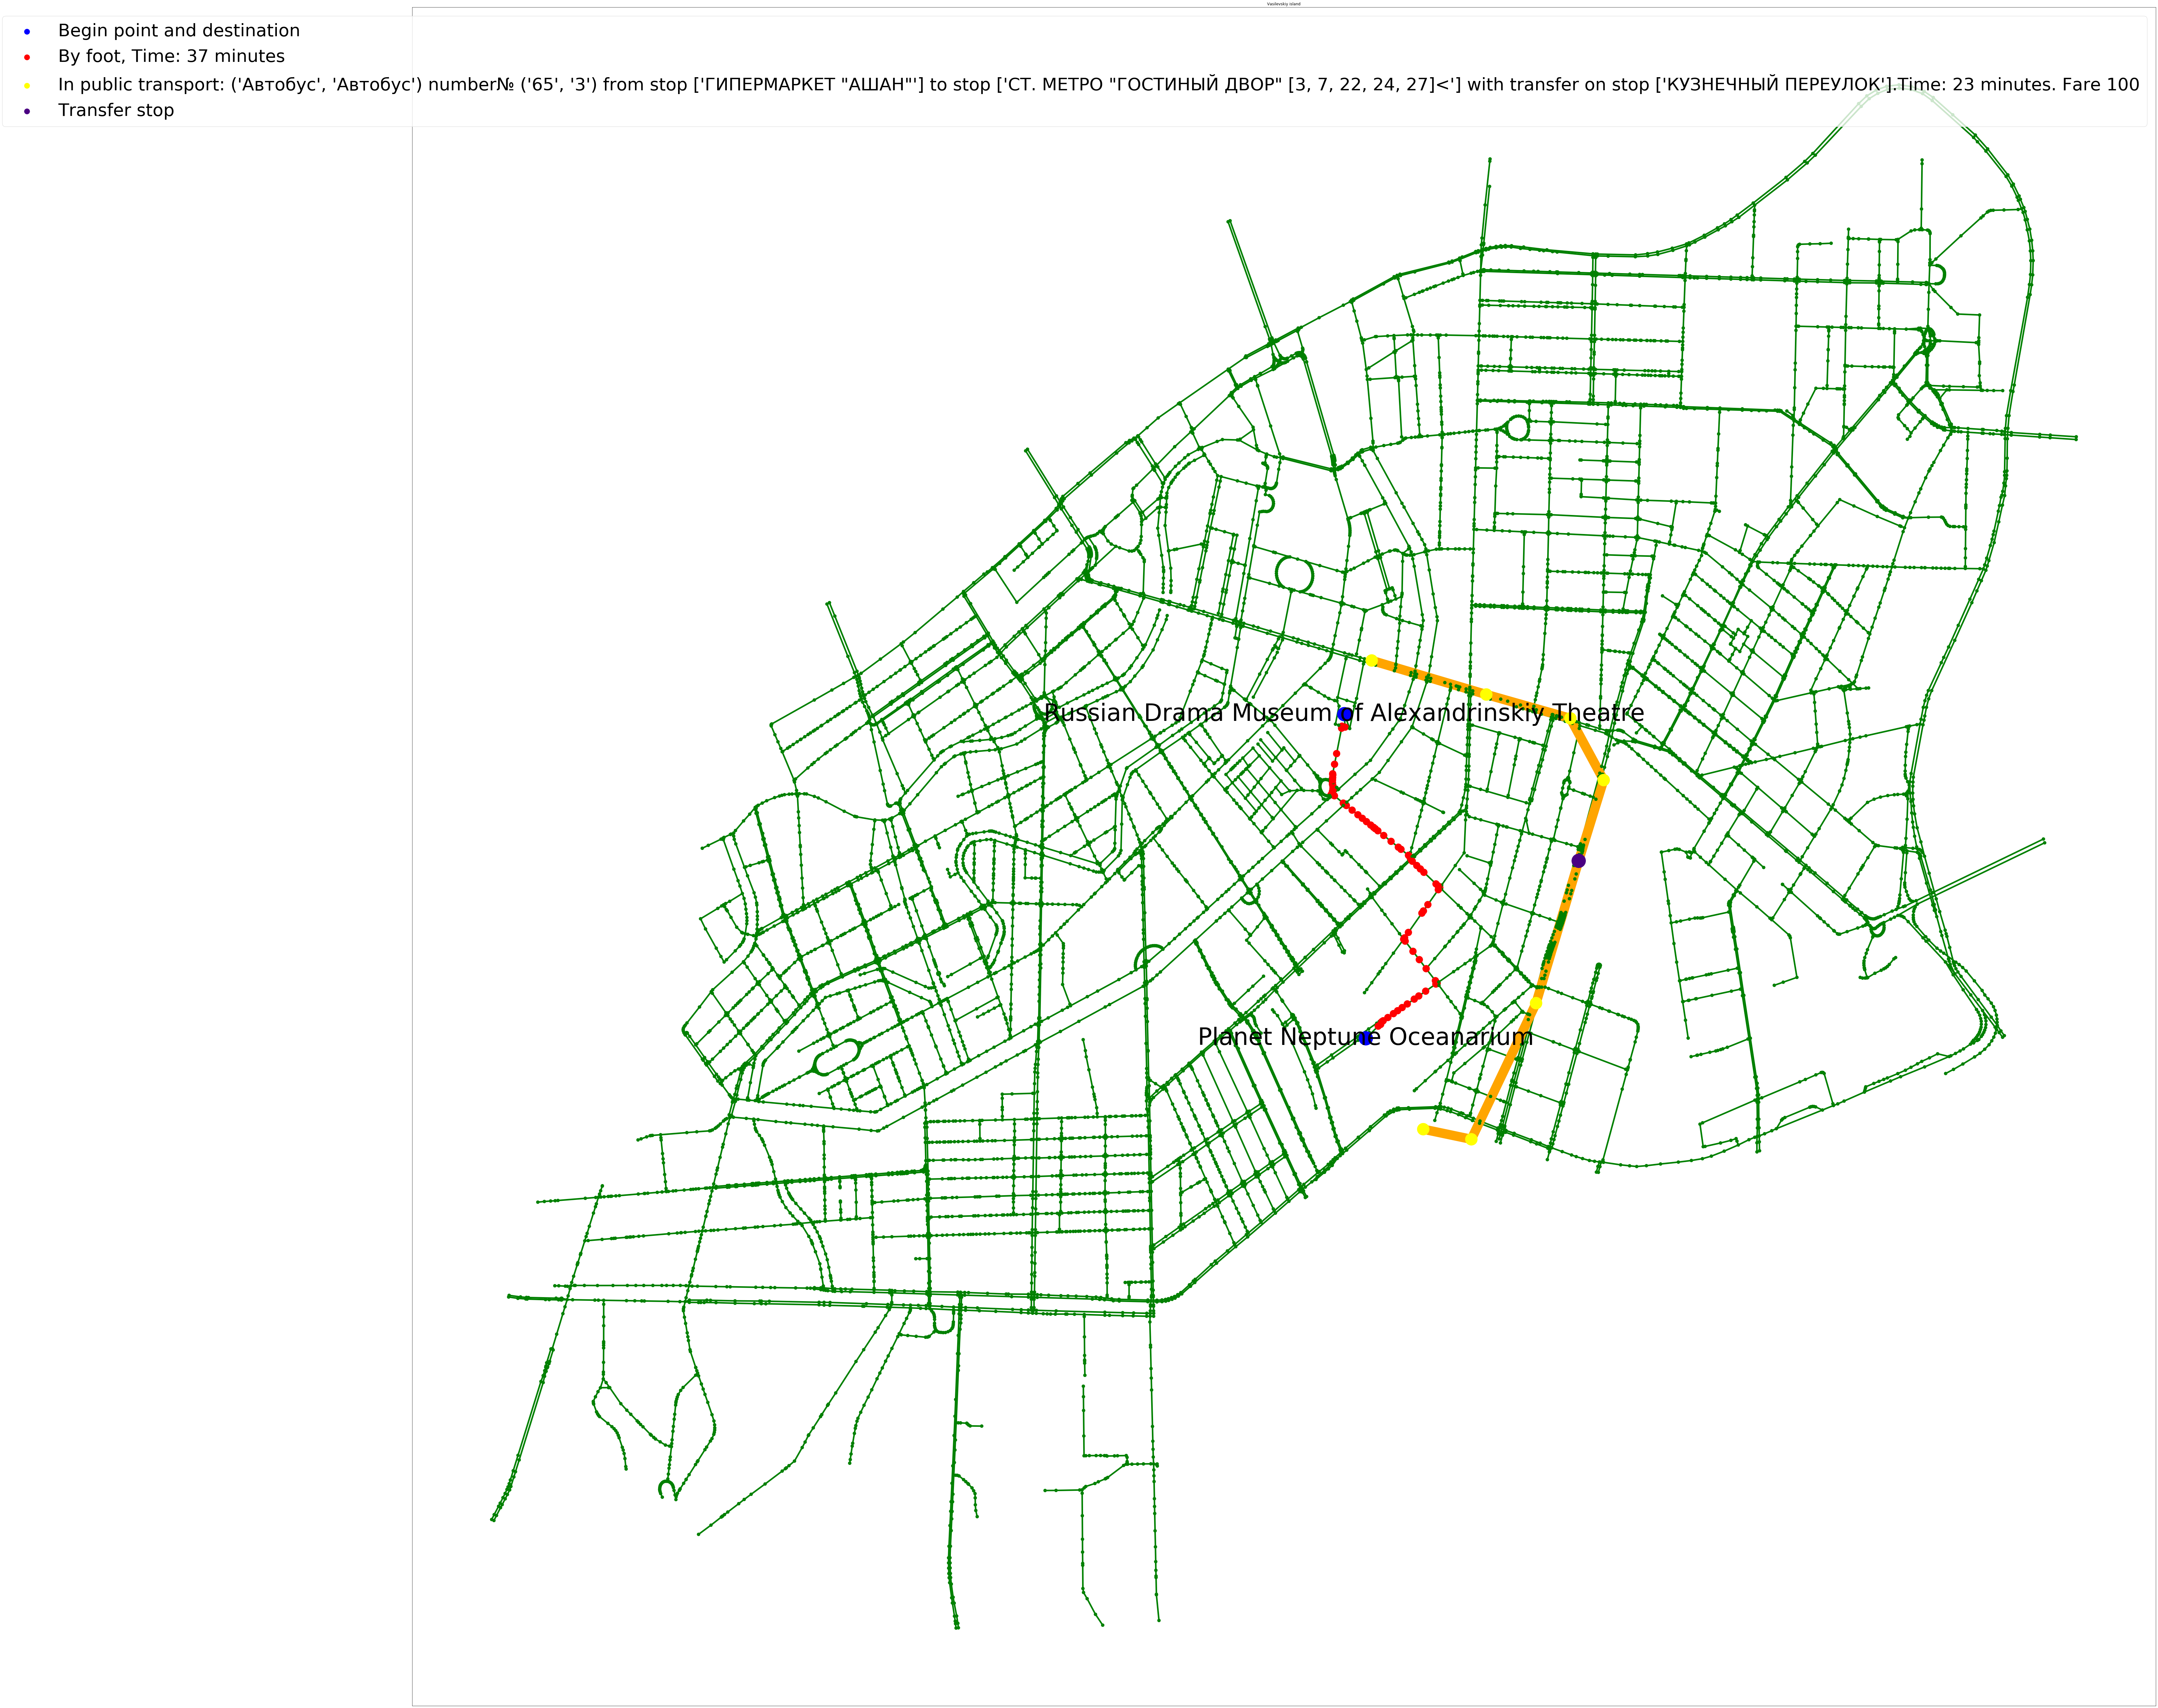

In [41]:
visualization1(begin_end)

In [52]:
f = open("weight_centralnii_district.txt", "r")
weights = [line.rstrip('\n') for line in f]
print(weights)

['0.005864331664917601', '0.010335575628311196', '0.06099484784783353', '0.005469927923031144', '0.08032811119426103', '0.002441978595189127', '0.0026312764437305724', '0.002479434690994859', '0.004846110048939286', '0.0063516234750065495', '0.006162410308471207', '0.01527935787399959', '0.008078025702452876', '0.01988737643787939', '0.007142993589325521', '0.010151071518675232', '0.005485511473424855', '0.02213304331840794', '0.015298529575626642', '0.04661882787437878', '0.012040304547051385', '0.012271266628409157', '0.026828151602359955', '0.005726056072947158', '0.018113196418816868', '0.006864074131330013', '0.02616243536503034', '0.007866230839388842', '0.027483455493560592', '0.020475529947726778', '0.0035179587512934067', '0.06295858150555321', '0.0024678351932031274', '0.035774015639207735', '0.0023615483419552425', '0.009707508102554068', '0.012870133867309128', '0.08027877597054903', '0.056455129913495355', '0.014133084941608086', '0.015396003927033277', '0.0328040905211039

In [102]:
'''
weights = []
for k in district:
    f = open(f"weight_{k}", "r")
    weight = [line.rstrip('\n') for line in f]
    weights.extend(weight)
i = 0
while i < len(weights):
    
'''


import geopy.distance
from geopy.distance import geodesic
for edge in G.edges:
    G[edge[0]][edge[1]]['weight'] = geopy.distance.geodesic(edge[0],edge[1]).km

        #print(edge)
        #G[edge] = float(weights[edge])
        #G[list(edge[0])][list(edge[1])]['weight'] = float(weights[edge])

In [106]:
G.get_edge_data(edge[0],edge[1])

{'weight': 1.1863322806545784}

In [107]:
edge[0],edge[1]

((30.3494244, 59.9325665409273), (30.3387852, 59.9338942714224))

In [100]:
len(weights)

12304

In [37]:
def dataForViz(opt):
    df = pd.read_csv("public_transport_spb")
    typeOfTransport = list(df.loc[df['route_short_name'] == opt[0][0]]['transport_type'])[0]
    beginStop = df.loc[df['coordinates'] == opt[2]]["stop_name"].iloc[0] 
    endStop = df.loc[df['coordinates'] == opt[3]]["stop_name"].iloc[0]
    quant = len(data)
    return typeOfTransport, beginStop, endStop, quant

In [46]:
# translate to geojson
'''
busStops = f
from geojson import MultiLineString
byTransport = MultiLineString(busStops)
from geojson import Point, Feature, FeatureCollection, dump

features = []
features.append(Feature(geometry = byTransport, properties={"type": "Bus"}))

feature_collection = FeatureCollection(features)

with open('byTransport.geojson', 'w') as f:
    dump(feature_collection, f)
    
'''

'\nbusStops = f\nfrom geojson import MultiLineString\nbyTransport = MultiLineString(busStops)\nfrom geojson import Point, Feature, FeatureCollection, dump\n\nfeatures = []\nfeatures.append(Feature(geometry = byTransport, properties={"type": "Bus"}))\n\nfeature_collection = FeatureCollection(features)\n\nwith open(\'byTransport.geojson\', \'w\') as f:\n    dump(feature_collection, f)\n    \n'

In [45]:
# begin stops, end stops, transfer stops
'''
from geojson import Point, Feature, FeatureCollection, dump
from geojson import MultiPoint

try:
    stopsTransport = MultiPoint([convertBusesStops[0], convertBusesStops[-1], stopTransfer])
except:
    stopsTransport = MultiPoint([convertBusesStops[0], convertBusesStops[-1], stopTransfer])


features = []
features.append(Feature(geometry = stopsTransport, properties={"type": "Stops"}))

feature_collection = FeatureCollection(features)

with open('stops.geojson', 'w') as f:
    dump(feature_collection, f)
'''

'\nfrom geojson import Point, Feature, FeatureCollection, dump\nfrom geojson import MultiPoint\n\ntry:\n    stopsTransport = MultiPoint([convertBusesStops[0], convertBusesStops[-1], stopTransfer])\nexcept:\n    stopsTransport = MultiPoint([convertBusesStops[0], convertBusesStops[-1], stopTransfer])\n\n\nfeatures = []\nfeatures.append(Feature(geometry = stopsTransport, properties={"type": "Stops"}))\n\nfeature_collection = FeatureCollection(features)\n\nwith open(\'stops.geojson\', \'w\') as f:\n    dump(feature_collection, f)\n'

In [52]:
# by foot
from geojson import Point, Feature, FeatureCollection, dump
from geojson import MultiPoint

byFoot = MultiPoint(pat)


features = []
features.append(Feature(geometry = byFoot, properties={"type": "byFoot"}))

feature_collection = FeatureCollection(features)

with open('byFoot.geojson', 'w') as f:
    dump(feature_collection, f)

In [53]:
# begin_end
from geojson import Point, Feature, FeatureCollection, dump
from geojson import MultiPoint

beginEnd = MultiPoint([(begin[1], begin[0]), (end[1], end[0])])


features = []
features.append(Feature(geometry = beginEnd, properties={"type": "beginEnd"}))

feature_collection = FeatureCollection(features)

with open('beginEnd.geojson', 'w') as f:
    dump(feature_collection, f)

In [54]:
from geojson import Point, Feature, FeatureCollection, dump
from geojson import MultiPoint

allStopsBuses = MultiPoint(convertBusesStops)


features = []
features.append(Feature(geometry = allStopsBuses, properties={"type": "allStops"}))

feature_collection = FeatureCollection(features)

with open('allStops.geojson', 'w') as f:
    dump(feature_collection, f)

In [2]:
print(find('Russian Drama Museum of Alexandrinskiy Theatre'))
print(find('State Academical Mariinskiy Theatre'))

(59.9318, 30.33624)
(59.92575, 30.296333)


In [3]:
    end_name = 'Russian Drama Museum of Alexandrinskiy Theatre'
    begin_name = 'Planet Neptune Oceanarium'
    
    #end = (59.942927, 30.278159)
    begin = find(begin_name)
    end = find(end_name)

In [58]:
begin

(59.920746, 30.387825)

In [59]:
end

(59.936516, 30.302124)

In [21]:
import json
district = ['centralnii_district.txt', "vasileostrovskii_district.txt"]

In [22]:
    coordsAll = []
    for i in district:
        import json
        with open(i, 'r') as file:
            data = json.load(file)
            import numpy as np
            import matplotlib.pyplot as plt
            coords = [[] for x in range(len(data['elements']))]
            for i in range(len(data['elements'])):
                if 'geometry' in data['elements'][i]:
                        for j in range(len(data['elements'][i]['geometry'])):
                            lon = data['elements'][i]['geometry'][j]['lon']
                            lat = data['elements'][i]['geometry'][j]['lat']
                            coords[i].append((lon, lat))

            coordsAll.extend(coords)

In [24]:
len(coordsAll)

2408

In [30]:
coordsAll[2403]

[(30.2607625, 59.9437839),
 (30.2609128, 59.9436542),
 (30.2612248, 59.9433913),
 (30.2612729, 59.9433507),
 (30.2613326, 59.9433005)]

In [19]:
    import pandas as pd
    import geopy.distance
    import networkx as nx
    
    end_name = "Bronze Horseman, Monument To Peter I"
    #end_name = "Nicholas Naval Cathedral of The Epiphany"
    
    # begin_name = "Holy Trinity Alexander Nevskiy' Lavra"
    begin_name = "New Holland Island"
    
    #begin_name = 'Russian Drama Museum of Alexandrinskiy Theatre'
    #end_name = 'State Academical Mariinskiy Theatre'
    #end_name = 'Russian Drama Museum of Alexandrinskiy Theatre'
    #begin_name = 'Planet Neptune Oceanarium'
    
    # end_name = "Peter and Paul Fortress (Petropavlovskaya Krepost)"

    
    #begin_name = "Memorial Sign Strelka Of Vasilievskiy Island"
    #begin_name = "St. Isaac's Cathedral State Museum-Memorial"
    #begin_name = 'Russian Drama Museum of Alexandrinskiy Theatre'
    #end_name = "Peter and Paul Fortress (Petropavlovskaya Krepost)"
    
    #end = (59.942927, 30.278159)
    begin = find(begin_name)
    end = find(end_name)
    begin_end = (begin, end)

In [58]:
    district = findDistrict(begin, end, coosdinatesStopsBuses)
    coordsAll = unionCoords(district)
    
    coordsAll = findLocation(begin)
    coordsAll = findLocation(end)
    coords = coordsAll
    
    b = forBuild(coords)
    
'''
    G = createGraph(b, f)
    pos = Pos(G)
    pat = shortestPath(begin_end[0], begin_end[1], G)
    distFoot = distOnFoot(pat)
    timeFoot = timeOnFoot(pat)
    '''

'\nG = createGraph(b, f)\npos = Pos(G)\npat = shortestPath(begin_end[0], begin_end[1], G)\ndistFoot = distOnFoot(pat)\ntimeFoot = timeOnFoot(pat)\n'

In [61]:
    b = []
    for i in range(len(coords)):
        a = coords[i]
        for v,w in zip(a[:-1], a[1:]):
            b.append([v,w])

[[(30.2629262, 59.9094874), (30.2632919, 59.9094867)],
 [(30.2632919, 59.9094867), (30.2638999, 59.9094726)],
 [(30.3174, 59.9266139), (30.3173345, 59.9266948)],
 [(30.2931771, 59.9172818), (30.2930912, 59.9172624)],
 [(30.2930912, 59.9172624), (30.2927319, 59.9171807)],
 [(30.2927319, 59.9171807), (30.2926134, 59.9171551)],
 [(30.2926134, 59.9171551), (30.2924134, 59.9171114)],
 [(30.2924134, 59.9171114), (30.2921791, 59.9170594)],
 [(30.2921791, 59.9170594), (30.292017, 59.9170234)]]

In [66]:
distFoot

1.964600854924413